In [79]:
import re
import time
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import scipy.stats as stats

%load_ext autoreload
%autoreload 2

In [2]:
local_path = f'../housing_crawler/data/all_encoded.csv'
df = pd.read_csv(local_path)
df.head()

,id,url,type_offer,landlord_type,title,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,...,kitchen,shower_type,tv,floor_type,heating,public_transport_distance,internet,parking,extras,schufa_needed
0,7100091,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,01.09. - 22.09.2022 +++ SUBLET - Möbliertes 26...,500,26,1.0,2,1,...,NaN,Dusche,NaN,Dielen,Zentralheizung,2 Minuten zu Fuß entfernt,"DSL, WLAN 26-50 Mbit/s",gute Parkmöglichkeiten,"Waschmaschine, Spülmaschine, Garten",NaN
1,9534572,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Privatzimmer mit Balkon zentral,50,30,1.0,2,2,...,NaN,NaN,Kabel,Dielen,Zentralheizung,3 Minuten zu Fuß entfernt,WLAN,NaN,Balkon,NaN
2,9534584,https://www.wg-gesucht.de/1-zimmer-wohnungen-i...,1 Zimmer Wohnung,Private,Großes möbliertes Zimmer - geselliges Studente...,500,20,1.0,0,0,...,NaN,Badewanne,Satellit,Parkett,NaN,NaN,NaN,NaN,"Waschmaschine, Balkon",NaN
3,9534654,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Großes teilmöbliertes Zimmer im schönen Witte...,450,18,1.0,5,2,...,NaN,NaN,NaN,NaN,NaN,1 Minute zu Fuß entfernt,"DSL, WLAN schneller als 100 Mbit/s",gute Parkmöglichkeiten,"Waschmaschine, Spülmaschine, Balkon, Fahrradke...",NaN
4,9534629,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Zimmer in Studentenwohnheim Zehlendorf 18qm,540,18,1.0,2,1,...,NaN,NaN,NaN,NaN,NaN,3 Minuten zu Fuß entfernt,NaN,NaN,NaN,NaN


In [5]:
def filter_out_bad_entries(ads_df=df, country = 'Germany',
                           price_max = 4000, price_min = 50,
                          size_max = 400, size_min = 3,
                          date_max = None, date_min = None, date_format = "%d.%m.%Y"):
    
    try:
        # Filter ads in between desired dates. Standard is to use ads from previous 3 months
        if date_max == None or date_max == 'today':
            date_max = pd.to_datetime(time.strftime(date_format, time.localtime()), format = date_format)
        elif isinstance(date_max,str):
            date_max = pd.to_datetime(date_max, format = date_format)

        if date_min == None:
            date_min = datetime.date.today() + relativedelta(months=-3)
            date_min = pd.to_datetime(date_min.strftime(date_format), format = date_format)
        elif isinstance(date_min,str):
            date_min = pd.to_datetime(date_min, format = date_format)

        ads_df['temp_col'] = ads_df['published_on'].apply(lambda x: x >= date_min and x <= date_max)

        ads_df = ads_df[ads_df['temp_col']].drop(columns=['temp_col'])
    except ValueError:
        print('Date format was wrong. Please input a date in the format 31.12.2020 (day.month.year), or specify the date format you want to use using the "date_format" option.')

    
    ## Filter out unrealistic offers
    ads_df = ads_df.query(f'price_euros <= {price_max}\
                         & price_euros > {price_min}\
                         & size_sqm <= {size_max}\
                         & size_sqm >= {size_min}')
    
    if country.lower() in ['germany', 'de']:
        # Germany bounding box coordinates from here: https://gist.github.com/graydon/11198540
        ads_df['latitude'] = [lat if (lat>47.3024876979 and lat<54.983104153) else np.nan for lat in list(ads_df['latitude'])]
        ads_df['longitude'] = [lon if (lon>5.98865807458 and lon<15.0169958839) else np.nan for lon in list(ads_df['longitude'])]
    
    return ads_df

In [56]:
def transform_columns_into_numerical(ads_df = df):

    ## wg_possible
    # Only relevant for houses and flats
    # 1 = allowed to turn into WG
    # 0 = not allowed to turn into WG (no response)
    # NaN = not searched for details (see details_searched)
    
    ads_df['wg_possible'] = [0 if item != item else 1 for item in ads_df['wg_possible']] # np.nan doesn't equals itself
    ads_df.loc[ads_df['details_searched'] == 0, 'wg_possible'] = np.nan
    ads_df.loc[ads_df['type_offer_simple'] == 'Flatshare', 'wg_possible'] = 1.0
    
    
    ## building_floor
    # indicates the level from the ground. Ground level is 0.
    # Ambiguous values were given fractional definitions ('Hochparterre':0.5, 'Tiefparterre':-0.5).
    # 6 indicates values above 5, not necessarily the 6th floor
    # NaN = indicates lack of response or not searched for details (see details_searched)
    mapping_dict = {'EG':0, '1. OG':1, '2. OG':2, '3. OG':3, '4. OG':4, '5. OG':5, 'höher als 5. OG':6,
                    'Hochparterre':0.5, 'Dachgeschoss':2, 'Tiefparterre':-0.5, 'Keller':-1}
    ads_df['building_floor']= ads_df['building_floor'].map(mapping_dict)
    
    
    ## furniture
    # 1 = möbliert
    # 0.5 = teilmöbliert
    # 0 = no answer (assumed to be not furnitured)
    # NaN = not searched for details (see details_searched)
    mapping_dict = {'möbliert':1, 'teilmöbliert':0.5, 'möbliert, teilmöbliert':0.5}
    ads_df['furniture']= ads_df['furniture'].map(mapping_dict).replace(np.nan,0)
    ads_df.loc[ads_df['details_searched'] == 0, 'furniture'] = np.nan
    
    
    ## kitchen
    # 1 = kitchen ('Eigene Küche' or 'Einbauküche')
    # 0.75 = 'Kochnische' (room + kitchen)
    # 0.5 = 'Küchenmitbenutzung' (shared kitchen)
    # 0 = no kitchen (Nicht vorhanden [not available] or no response)
    # NaN = not searched for details (see details_searched)
    mapping_dict = {'Nicht vorhanden':0, 'Küchenmitbenutzung':0.5, 'Kochnische':0.75, 'Eigene Küche':1, 'Einbauküche':1}
    ads_df['kitchen']= ads_df['kitchen'].map(mapping_dict).replace(np.nan,0)
    ads_df.loc[ads_df['details_searched'] == 0, 'kitchen'] = np.nan

    
    ## public_transport_distance
    # Distance in minutes to public transportation
    # NaN = indicates lack of response or not searched for details (see details_searched)
    ads_df['public_transport_distance'] = ads_df['public_transport_distance'].apply(lambda x: np.nan if x!=x else int(x.split(' Min')[0]))
    
    
    ## extras
    # 1 = yes
    # 0 = no answer (assumed to not exist)
    # NaN = not searched for details (see details_searched)
    unique_extras = ['Waschmaschine', 'Spülmaschine', 'Terrasse', 'Balkon', 'Garten', 'Gartenmitbenutzung', 'Keller', 'Aufzug',
                     'Haustiere', 'Fahrradkeller', 'Dachboden']

    for option in unique_extras:
        option_name = 'extras_' + option.lower().replace('ü','ue')
        ads_df[option_name] = np.nan
        ads_df.loc[ads_df['details_searched'] == 1.0, option_name] = 0.0
        ads_df.loc[[option in item if item==item else False for item in ads_df['extras'] ], option_name] = 1
    ads_df = ads_df.drop(columns=['extras'])
    
    
    ## languages
    # 1 = yes
    # 0 = no answer (assumed to not exist)
    # NaN = not searched for details (see details_searched)
    unique_languages = ['Deutsch', 'Englisch']

    for option in unique_languages:
        option_name = 'languages_' + option.lower().replace('ü','ue')
        ads_df[option_name] = np.nan
        ads_df.loc[ads_df['details_searched'] == 1.0, option_name] = 0.0
        ads_df.loc[[option in item if item==item else False for item in ads_df['extras'] ], option_name] = 1
    
    ## Number of languages
    # NaN = no answer or not searched for details (see details_searched)
    ads_df['number_languages'] = ads_df['languages'].apply(lambda x: len(str(x).split(',')) if x == x else np.nan)

    
    ads_df = ads_df.drop(columns=['languages'])
    
    
    ## smoking
    # 1 = allowed everywhere
    # 0.75 = allowed in room
    # 0.5 = allowed in the balcony (outside)
    # 0 = not allowed or no response
    # NaN = not searched for details (see details_searched)
    mapping_dict = {'Rauchen nicht erwünscht':0, 'Rauchen auf dem Balkon erlaubt':0.5, 'Rauchen im Zimmer erlaubt':0.75, 'Rauchen überall erlaubt':1}
    ads_df['smoking']= ads_df['smoking'].map(mapping_dict).replace(np.nan,0)
    ads_df.loc[ads_df['details_searched'] == 0, 'smoking'] = np.nan
    
    
    ## Age range
    # min age range
    ads_df['min_age_flatmates'] = np.nan
    ads_df['min_age_flatmates'] = [np.nan if item != item else \
                                   np.nan if str(item).startswith('bis') else \
                               re.findall('[0-9]+', item)[0] \
                               for item in list(ads_df['age_range'])]
    
    # max age range
    ads_df['max_age_flatmates'] = np.nan
    ads_df['max_age_flatmates'] = [np.nan if item != item else \
                                   np.nan if str(item).startswith('ab') else \
                                   re.findall('[0-9]+', item)[0] if str(item).startswith('bis') else \
                               re.findall('[0-9]+', item)[1] \
                               for item in list(ads_df['age_range'])]

    return ads_df

In [ ]:
def hot_encode_columns(ads_df = df):
    
    
    ## wg_type
    # 1 = yes
    # 0 = no answer (assumed to not exist)
    # NaN = not searched for details (see details_searched)
    unique_wg_type = ['Studenten-WG', 'keine Zweck-WG', 'Männer-WG', 'Business-WG', 'Wohnheim', 'Vegetarisch/Vegan', 
                   'Alleinerziehende', 'funktionale WG', 'Berufstätigen-WG', 'gemischte WG', 'WG mit Kindern', 
                   'Verbindung', 'LGBTQIA+', 'Senioren-WG', 'inklusive WG', 'WG-Neugründung']
    
    for option in unique_wg_type:
        option_name = 'wg_type_' + option.lower().replace('-wg','').replace(' wg','').replace('wg ','')\
        .replace('ä','ae').replace(' ','_').replace('/','_').replace('-','_').replace('+','')
        ads_df[option_name] = np.nan
        ads_df.loc[ads_df['details_searched'] == 1.0, option_name] = 0.0
        ads_df.loc[[option in item if item==item else False for item in ads_df['wg_type'] ], option_name] = 1
#     ads_df = ads_df.drop(columns=['wg_type'])
    
    
    ## tv
    # 1 = yes
    # 0 = no answer (assumed to not exist)
    # NaN = no answer or not searched for details (see details_searched)
    unique_tv = ['Kabel', 'Satellit']
    
    for option in unique_tv:
        option_name = 'tv_' + option.lower()
        ads_df[option_name] = np.nan
        ads_df.loc[ads_df['details_searched'] == 1.0, option_name] = 0.0
        ads_df.loc[[option in item if item==item else False for item in ads_df['tv'] ], option_name] = 1
#     ads_df = ads_df.drop(columns=['tv'])



    return ads_df

In [57]:
def feature_engineering(ads_df = df):
    # Create day of the week column with first 3 letters of the day name
    ads_df['day_of_week_publication'] = ads_df['published_on'].dt.day_name()
    ads_df['day_of_week_publication'] = [day[0:3] for day in list(ads_df['day_of_week_publication'])]
    
    # Create price/sqm column
    ads_df['price_per_sqm'] = round(ads_df['price_euros']/ads_df['size_sqm'],2)
    
    # Create available time measured in days
#     ads_df['time_available'] = ads_df.apply(lambda x: print(x['published_on']), axis = 1)
    
    ads_df['days_available'] = ads_df.apply(lambda x: get_availablility_time(published_on=x['published_on'], 
                                                                             available_to=x['available_to'], 
                                                                             available_from=x['available_from']), axis = 1)

    return ads_df

In [58]:
df_processed = df.copy()
df_processed = prepare_data(ads_df = df_processed)
# df_processed = filter_out_bad_entries(ads_df=df_processed)
df_processed = transform_columns_into_numerical(ads_df = df_processed)
df_processed = feature_engineering(ads_df = df_processed)

# df_processed = df_processed.drop(columns=['url', 'title', 'crawler'])

In [60]:
df_processed.head(60)

,id,url,type_offer,landlord_type,title,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,...,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugründung,tv_kabel,tv_satellit,min_age_flatmates,max_age_flatmates,day_of_week_publication,price_per_sqm,days_available
0,7100091,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,01.09. - 22.09.2022 +++ SUBLET - Möbliertes 26...,500,26,1.0,2,1,...,0.0,0.0,0.0,0.0,0.0,33,33,Thu,19.23,21
1,9534572,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Privatzimmer mit Balkon zentral,50,30,1.0,2,2,...,0.0,0.0,0.0,1.0,0.0,30,31,Thu,1.67,20
2,9534584,https://www.wg-gesucht.de/1-zimmer-wohnungen-i...,1 Zimmer Wohnung,Private,Großes möbliertes Zimmer - geselliges Studente...,500,20,1.0,0,0,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,Thu,25.00,395
3,9534654,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Großes teilmöbliertes Zimmer im schönen Witte...,450,18,1.0,5,2,...,0.0,0.0,0.0,0.0,0.0,25,30,Thu,25.00,0
4,9534629,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Zimmer in Studentenwohnheim Zehlendorf 18qm,540,18,1.0,2,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Thu,30.00,0
5,4568391,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Krille‘s Bude,500,25,1.0,3,2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Thu,20.00,46
6,9532515,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,3 Wochen - Gemütliches Zimmer in Steglitz,400,25,1.0,4,1,...,0.0,0.0,0.0,0.0,0.0,23,26,Thu,16.00,23
7,9344285,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Room in Adlershof - Long Term only,400,26,1.0,2,1,...,0.0,0.0,0.0,0.0,0.0,36,39,Thu,15.38,0
8,9534758,https://www.wg-gesucht.de/wohnungen-in-Berlin-...,2 Zimmer Wohnung,Private,Cozy 2-room apartment in Berlin-Friedrichshain,1400,67,2.0,0,0,...,0.0,0.0,0.0,1.0,0.0,NaN,NaN,Thu,20.90,60
9,9534729,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Room to subrent (september-october 2022),600,25,1.0,2,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Thu,24.00,60


In [28]:
sorted(df_processed.columns, reverse=False)

['address',
 'age_range',
 'available_from',
 'available_rooms',
 'available_spots_wg',
 'available_to',
 'building_floor',
 'building_type',
 'capacity',
 'city',
 'cold_rent_euros',
 'crawler',
 'deposit',
 'details_searched',
 'diverse_flatmates',
 'energy',
 'extra_costs_euros',
 'extras',
 'extras_aufzug',
 'extras_balkon',
 'extras_dachboden',
 'extras_fahrradkeller',
 'extras_garten',
 'extras_gartenmitbenutzung',
 'extras_haustiere',
 'extras_keller',
 'extras_spuelmaschine',
 'extras_terrasse',
 'extras_waschmaschine',
 'female_flatmates',
 'floor_type',
 'furniture',
 'gender_search',
 'heating',
 'home_total_size',
 'id',
 'internet',
 'kitchen',
 'landlord_type',
 'landlord_type_private',
 'landlord_type_verifiziert',
 'languages',
 'latitude',
 'longitude',
 'male_flatmates',
 'mandatory_costs_euros',
 'parking',
 'price_euros',
 'public_transport_distance',
 'published_at',
 'published_on',
 'schufa_needed',
 'shower_type',
 'size_sqm',
 'smoking',
 'title',
 'transfer_co

In [122]:
df_processed['languages'].value_counts()

Deutsch, Englisch                                                 474
Deutsch                                                           123
Deutsch, Englisch, Französisch                                     71
Deutsch, Englisch, Spanisch                                        62
Deutsch, Englisch, Spanisch, Französisch                           24
                                                                 ... 
Deutsch, Englisch, Spanisch, Französisch, Russisch, Schwedisch      1
Deutsch, Spanisch, Russisch                                         1
Englisch, Hindi, Deutsch                                            1
Deutsch, Norwegisch                                                 1
Deutsch, Englisch, Spanisch, Arabisch                               1
Name: languages, Length: 109, dtype: int64

In [23]:
ages = re.findall('[0-9]+', '20 bis 25 Jahre')
'ab' in '18 bis 60 Jahre'

False

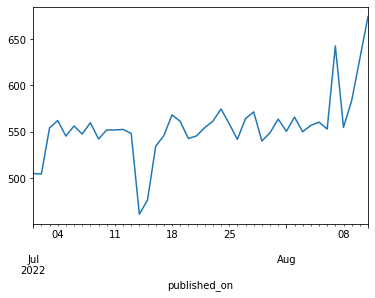

In [76]:
df_processed[df_processed['published_on'] >= pd.to_datetime('01.07.2022', format = "%d.%m.%Y")].set_index('published_on').resample('D').mean()['price_euros'].plot();

In [90]:
df_processed_wg = df_processed[df_processed['type_offer_simple'] == 'Flatshare']
df_processed_wg.head()

,id,url,type_offer,landlord_type,title,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,...,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugründung,tv_kabel,tv_satellit,min_age_flatmates,max_age_flatmates,day_of_week_publication,price_per_sqm,days_available
0,7100091,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,01.09. - 22.09.2022 +++ SUBLET - Möbliertes 26...,500,26,1.0,2,1,...,0.0,0.0,0.0,0.0,0.0,33,33,Thu,19.23,21
1,9534572,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Privatzimmer mit Balkon zentral,50,30,1.0,2,2,...,0.0,0.0,0.0,1.0,0.0,30,31,Thu,1.67,20
3,9534654,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Großes teilmöbliertes Zimmer im schönen Witte...,450,18,1.0,5,2,...,0.0,0.0,0.0,0.0,0.0,25,30,Thu,25.00,0
4,9534629,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Zimmer in Studentenwohnheim Zehlendorf 18qm,540,18,1.0,2,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Thu,30.00,0
5,4568391,https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...,WG,Private,Krille‘s Bude,500,25,1.0,3,2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Thu,20.00,46


In [113]:
model1 = smf.ols(formula = 'price_euros ~ size_sqm + city + capacity + building_type + building_floor + extras + furniture + floor_type + languages + wg_type + public_transport_distance -1', data=df_processed_wg).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     2.602
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           2.04e-09
Time:                        13:56:40   Log-Likelihood:                -2956.3
No. Observations:                 533   AIC:                             6741.
Df Residuals:                     119   BIC:                             8512.
Df Model:                         413                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================================================================================================================================================================================================================================================================================================
                                                                                                                                                                                                                                                                                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
city[Aachen]                                                                                                                                                                                                                                                                                                                                          168.6602    120.862      1.395      0.165     -70.659     407.979
city[Berlin]                                                                                                                                                                                                                                                                                                                                          317.5999     57.218      5.551      0.000     204.303     430.896
city[Bonn]                                                                                                                                                                                                                                                                                                                                            289.3405    187.802      1.541      0.126     -82.527     661.208
city[Bremen]                                                                                                                                                                                                                                                                                                                                          136.4872    163.070      0.837      0.404    -186.407     459.382
city[Darmstadt]                                                                                                                                                                                                                    

In [126]:
df_processed['number_languages'] = df_processed['languages'].apply(lambda x: len(str(x).split(',')) if x == x else np.nan)
df_processed[['languages', 'number_languages']]

,languages,number_languages
0,"Deutsch, Englisch",2.0
1,"Türkisch, Deutsch, Englisch",3.0
2,NaN,NaN
3,"Deutsch, Englisch",2.0
4,Englisch,1.0
...,...,...
54417,NaN,NaN
54418,NaN,NaN
54419,NaN,NaN
54420,NaN,NaN
